In [2]:
import numpy as np
import matplotlib.pyplot as plt

Direct digital synthesis is a phase controlled oscillator which you can use to generate arbitrary waveforms. DDS does this by controlling the instantaneous phase of a sine wave using a digital counter and a variable hop distance. At each time step, the phase is used to index a look up table with sine values. 

DDS visualized as a circle which has been sampled at $2^N$ points. A phase counter starts at 0 and overruns at $2^N$. At each clock cycle the counter or phase accumulator is incremented by a tuning word. The phase accumulator is then  used to access a sine wave encoded as a LUT. A sine wave is used so that a quarter of the sine wave need only be saved on the device. A drawback with the LUT is that as the frequency resolution increases the LUT necessarily increases too. At it's limit if amplitude is encoded with a 8bit number the frequency output for $2^{32}$ bits, GB of onboard memory is needed. The most significant bits of the phase accumulator are used to index the lut. The effect this has on the signal is to quantize the amplitude to short jumps. 

The relationship between output frequency, the tuneing word, and bit resolution is as follows:

$$ f = \frac{Mf_{clk}}{2^N} $$

where $M$ is the binary tuning word, $f_{clk}$ is the internal reference cock frequency, and $N$ is the length in bits.

Some comments on sampling: 
    - $M$ should be at most half $2^N$ or $2^(N-1)$ since the reconstruction frequency is fclk and fclk/2 is the Nyquist frequency
    - 
    

***intuition***
The counter rolls over every $2^N$ clock cycles. Therefore, the period of time to reach the rollover point is $2^N T_{clk}$, where $T_{clk}$ is one clock cycle. Inverting this period of time is the minimum frequency you can achieve with a DDS given an input clock frequency. Skipping every $M$ samples causes the counter to roll over more frequently. The output frequency is proportional to the number of skipped samples. 

Designers tradeoff between the the phase resolution, clock frequency, bit depth of each element in the LUT, and the length of the LUT. The smallest frequency resolution you can get is by counting up by 1 increment each clock cycle. DC is incrementing the counter by 0.



In [17]:
fout = lambda M,N,fclk: M*fclk/(2**N)

frequency resolution: 0.00011641532182693481 Hz


250000.0

6.4e-07
1562500.0


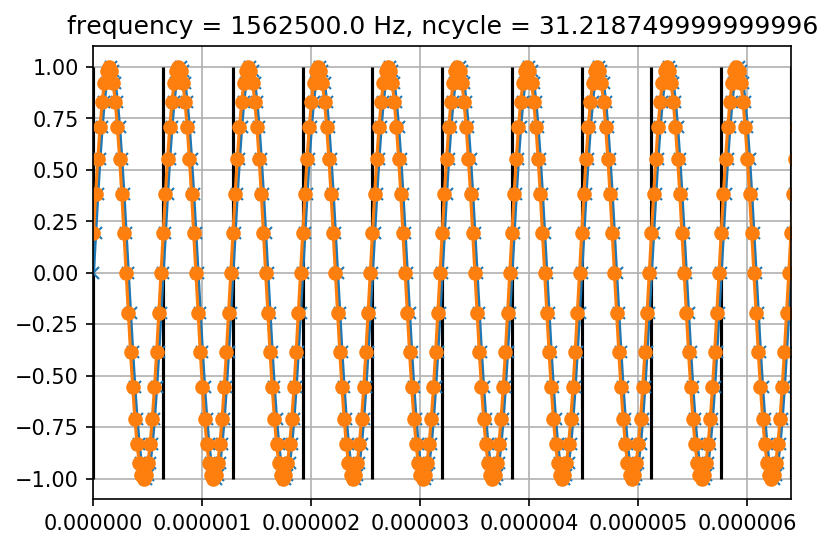

In [95]:
#simulation constants
cycle_no = 0
cycles_to_simulate =1000

#define the phase accumulator 

#define the LUT
fclk = 50E6
NLUT = 24

N = 32


M = 2**(N-5)
LUT = np.sin(2*np.pi*np.arange(0,2**NLUT)/(2**NLUT)) #LUT has same 

upper_bits = N - NLUT

#define the logic here
phase_accumulator = 0

#define input/output vectors
reset = np.zeros(cycles_to_simulate,dtype=np.bool)
enable = np.zeros(cycles_to_simulate,dtype=np.bool)
output = np.zeros(cycles_to_simulate,dtype=np.float)
phase = np.zeros(cycles_to_simulate,dtype=np.float)
t = np.arange(0,cycles_to_simulate)/fclk

while True:
    ### insert logic here
    if reset[cycle_no]: #reset high
        phase_accumulator = 0
        
    if enable[cycle_no]: #enable high
        phase_accumulator = 0
    phase_accumulator += M
    phase_accumulator = np.mod(phase_accumulator,2**N)
    phase[cycle_no] = phase_accumulator
    
    _phase_idx = np.right_shift(phase_accumulator,upper_bits)
    output[cycle_no] = LUT[_phase_idx]

    ### end logic
    if cycle_no == cycles_to_simulate-1:
        break
    cycle_no += 1
    
#you can really only reconstruct frequencies up to 1/(fclk*2**N)/2

#lowest frequency 
T_to_complete = 1/fout(M,N,fclk)
print(T_to_complete)

_fout = fout(M,N,fclk)
print(_fout)
cycles_completed_in_simulation = t[-1]*_fout

plt.figure(dpi=150)
plt.plot(t,np.sin(2*np.pi*_fout*t),'-x')
plt.plot(t,output,'-o')
plt.grid()
plt.title('frequency = {} Hz, ncycle = {}'.format(_fout,cycles_completed_in_simulation))
_t = 0
while (_t < t[-1]):
    plt.vlines(_t,-1,1,'k')
    _t += 1/fout(M,N,fclk)
    
plt.xlim([0,10/fout(M,N,fclk)])
plt.show()